# NASA C-MAPSS Turbofan Engine Degradation - Exploratory Data Analysis

## Content

1. [Introduction & Setup](#1-introduction--setup)
2. [Data Loading](#2-data-loading)
3. [Dataset Overview](#3-dataset-overview)
4. [Single Engine Deep Dive - FD001](#4-single-engine-deep-dive---fd001)
5. [Sensor Analysis](#5-sensor-analysis-focus-on-fd001-todo)
6. [Operating Conditions Analysis](#6-operating-conditions-analysis)
7. [Next Steps](#7-next-steps)

## 1. Introduction & Setup

### Dataset Overview
The Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dataset 
contains run-to-failure simulations of turbofan engines under various operating conditions.

**Goal**: Predict Remaining Useful Life (RUL) of engines based on sensor readings.

**Dataset Details**:
- 4 sub-datasets (FD001-FD004) with varying complexity
- 21 sensor measurements per time cycle (column 6 - 26)
- 3 operational settings (column 3 - 6)
- Different time, in cycles (column 2)
- Multiple engines per dataset (column 1 for unit number)
- Each dataset consists of mulitple multivariate time series and is devided into training and testing subset
- The data can be considered to be from a fleet of enginges of the same type. For further information see readme.txt of dataset. 


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ipynbname
from pathlib import Path

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

#todo: find cleaner solution for accessing root folder
notebook_path = ipynbname.path()
notebook_path_parent = notebook_path.parent
notebook_root_path = notebook_path_parent.parent
DATA_PATH = Path(notebook_root_path) / "data/CMAPSSData"

print(f"Data directory: {DATA_PATH}")
print(f"Directory exists: {DATA_PATH.exists()}")

Data directory: /home/solaris/solaris-labs/cmapss_predict_maint_mvp/data/CMAPSSData
Directory exists: True


## 2. Data Loading
- Load all 4 datasets (train_FD001-004, test_FD001-004, RUL_FD001-004)
- Understand file structure
- Add column names (unit_number, time_cycles, op_setting_1-3, sensor_1-21)
- Display basic info (shape, dtypes, head)

In [3]:
"""
The dataset files are space-separated text files without headers.
We need to define column names and load all datasets.
"""

# Define column names
index_names = ['unit_number', 'time_cycles']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = [f'sensor_{i}' for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

print(f"Total columns: {len(col_names)}")
print(f"Column names: {col_names}\n")

# Function to load data
def load_cmapss_data(filename, data_path=DATA_PATH):
    """Load C-MAPSS dataset file"""
    filepath = data_path / filename
    df = pd.read_csv(filepath, sep='\s+', header=None, names=col_names)
    return df

# Load training datasets
train_fd001 = load_cmapss_data('train_FD001.txt')
train_fd002 = load_cmapss_data('train_FD002.txt')
train_fd003 = load_cmapss_data('train_FD003.txt')
train_fd004 = load_cmapss_data('train_FD004.txt')

# Load test datasets
test_fd001 = load_cmapss_data('test_FD001.txt')
test_fd002 = load_cmapss_data('test_FD002.txt')
test_fd003 = load_cmapss_data('test_FD003.txt')
test_fd004 = load_cmapss_data('test_FD004.txt')

# Load RUL (ground truth for test sets)
rul_fd001 = pd.read_csv(DATA_PATH / 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
rul_fd002 = pd.read_csv(DATA_PATH / 'RUL_FD002.txt', sep='\s+', header=None, names=['RUL'])
rul_fd003 = pd.read_csv(DATA_PATH / 'RUL_FD003.txt', sep='\s+', header=None, names=['RUL'])
rul_fd004 = pd.read_csv(DATA_PATH / 'RUL_FD004.txt', sep='\s+', header=None, names=['RUL'])

print("✓ All datasets loaded successfully!\n")

# Display basic info for FD001 (our focus dataset)
print("=" * 80)
print("TRAIN FD001 - Basic Information")
print("=" * 80)
print(f"Shape: {train_fd001.shape}")
print(f"Memory usage: {train_fd001.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

print("First 5 rows:")
print(train_fd001.head())

print("\nData types:")
print(train_fd001.dtypes.value_counts())

#TODO: If basic dataset statistics printed: add short explanation of dataset statistics
#print("\nBasic statistics:")
#print(train_fd001.describe().round(2))

Total columns: 26
Column names: ['unit_number', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']

✓ All datasets loaded successfully!

TRAIN FD001 - Basic Information
Shape: (20631, 26)
Memory usage: 4.09 MB

First 5 rows:
   unit_number  time_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1            1       -0.0007       -0.0004         100.0   
1            1            2        0.0019       -0.0003         100.0   
2            1            3       -0.0043        0.0003         100.0   
3            1            4        0.0007        0.0000         100.0   
4            1            5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  se

## 3. Dataset Overview
- Summary statistics for each dataset
- Number of engines per dataset
- Cycle length distribution per engine
- Compare complexity across FD001-FD004 (operating conditions, fault modes)
- Decision: Which dataset to focus on (recommend FD001 - simplest)

C-MAPSS Datasets Comparison
Dataset  Train Samples  Test Samples  Train Engines  Test Engines  Operating Conditions  Fault Modes
  FD001          20631         13096            100           100                     1            1
  FD002          53759         33991            260           259                     6            1
  FD003          24720         16596            100           100                     1            2
  FD004          61249         41214            249           248                     6            2


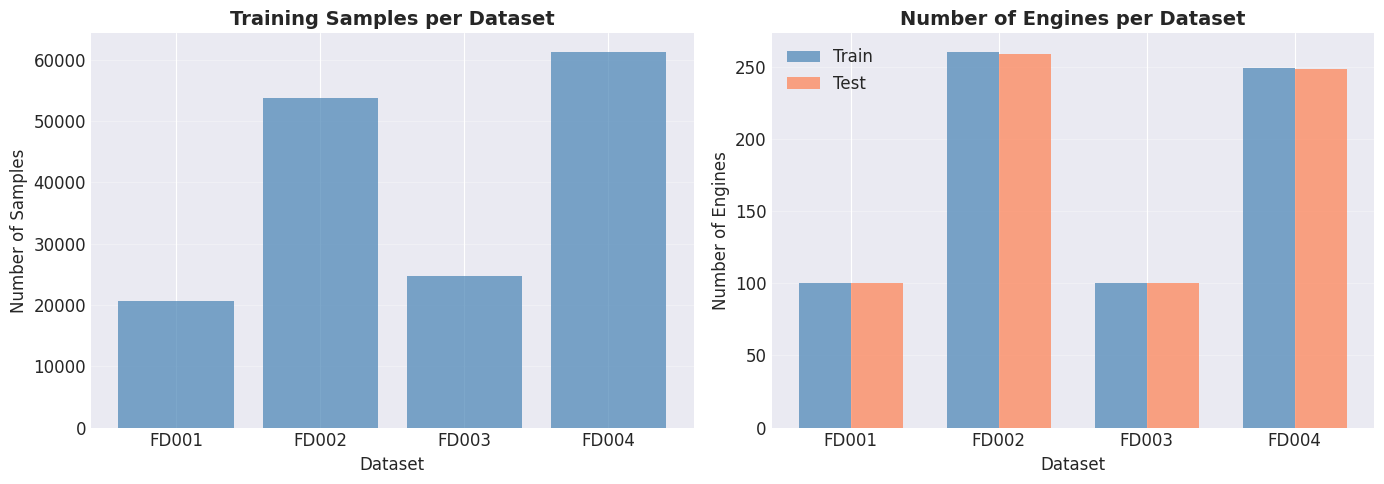


Cycle Length Statistics (Training Data)

FD001:
  Mean: 206.3 cycles
  Std:  46.3 cycles
  Min:  128 cycles
  Max:  362 cycles
  Median: 199.0 cycles

FD002:
  Mean: 206.8 cycles
  Std:  46.8 cycles
  Min:  128 cycles
  Max:  378 cycles
  Median: 199.0 cycles

FD003:
  Mean: 247.2 cycles
  Std:  86.5 cycles
  Min:  145 cycles
  Max:  525 cycles
  Median: 220.5 cycles

FD004:
  Mean: 246.0 cycles
  Std:  73.1 cycles
  Min:  128 cycles
  Max:  543 cycles
  Median: 234.0 cycles


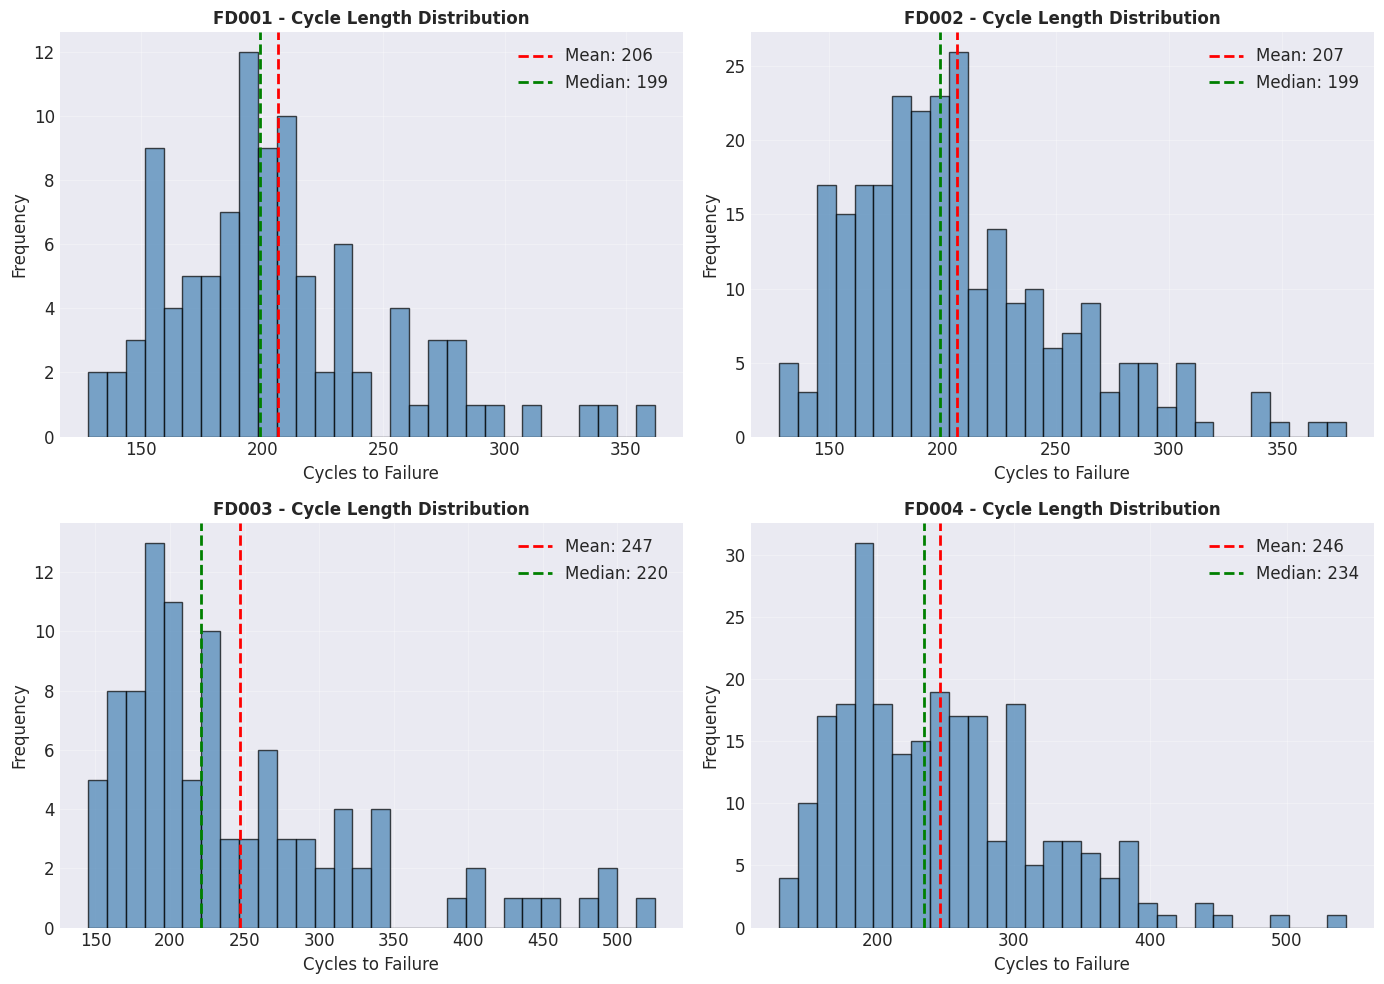


DECISION: Focus on FD001
Reasons:
✓ Simplest dataset (1 operating condition, 1 fault mode)
✓ Good for MVP and initial model development
✓ Most commonly used in research papers (easy to benchmark)
✓ Can expand to FD002-004 later for more complex scenarios


In [4]:
"""
Compare all 4 datasets to understand their complexity and decide which to focus on.
"""

# Create summary dataframe
datasets_info = {
    'Dataset': ['FD001', 'FD002', 'FD003', 'FD004'],
    'Train Samples': [len(train_fd001), len(train_fd002), len(train_fd003), len(train_fd004)],
    'Test Samples': [len(test_fd001), len(test_fd002), len(test_fd003), len(test_fd004)],
    'Train Engines': [train_fd001['unit_number'].nunique(), 
                      train_fd002['unit_number'].nunique(),
                      train_fd003['unit_number'].nunique(), 
                      train_fd004['unit_number'].nunique()],
    'Test Engines': [test_fd001['unit_number'].nunique(), 
                     test_fd002['unit_number'].nunique(),
                     test_fd003['unit_number'].nunique(), 
                     test_fd004['unit_number'].nunique()],
    'Operating Conditions': [1, 6, 1, 6],
    'Fault Modes': [1, 1, 2, 2]
}

df_summary = pd.DataFrame(datasets_info)
print("=" * 80)
print("C-MAPSS Datasets Comparison")
print("=" * 80)
print(df_summary.to_string(index=False))

# Visualize dataset sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training samples
axes[0].bar(df_summary['Dataset'], df_summary['Train Samples'], color='steelblue', alpha=0.7)
axes[0].set_title('Training Samples per Dataset', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xlabel('Dataset')
axes[0].grid(axis='y', alpha=0.3)

# Number of engines
x = np.arange(len(df_summary))
width = 0.35
axes[1].bar(x - width/2, df_summary['Train Engines'], width, label='Train', color='steelblue', alpha=0.7)
axes[1].bar(x + width/2, df_summary['Test Engines'], width, label='Test', color='coral', alpha=0.7)
axes[1].set_title('Number of Engines per Dataset', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Engines')
axes[1].set_xlabel('Dataset')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_summary['Dataset'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze cycle lengths
def get_cycle_stats(df):
    """Get cycle length statistics per engine"""
    cycle_lengths = df.groupby('unit_number')['time_cycles'].max()
    return {
        'mean': cycle_lengths.mean(),
        'std': cycle_lengths.std(),
        'min': cycle_lengths.min(),
        'max': cycle_lengths.max(),
        'median': cycle_lengths.median()
    }

print("\n" + "=" * 80)
print("Cycle Length Statistics (Training Data)")
print("=" * 80)

for name, df in [('FD001', train_fd001), ('FD002', train_fd002), 
                 ('FD003', train_fd003), ('FD004', train_fd004)]:
    stats = get_cycle_stats(df)
    print(f"\n{name}:")
    print(f"  Mean: {stats['mean']:.1f} cycles")
    print(f"  Std:  {stats['std']:.1f} cycles")
    print(f"  Min:  {stats['min']} cycles")
    print(f"  Max:  {stats['max']} cycles")
    print(f"  Median: {stats['median']:.1f} cycles")

# Visualize cycle length distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

datasets = [
    ('FD001', train_fd001),
    ('FD002', train_fd002),
    ('FD003', train_fd003),
    ('FD004', train_fd004)
]

for idx, (name, df) in enumerate(datasets):
    cycle_lengths = df.groupby('unit_number')['time_cycles'].max()
    
    axes[idx].hist(cycle_lengths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].axvline(cycle_lengths.mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {cycle_lengths.mean():.0f}')
    axes[idx].axvline(cycle_lengths.median(), color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {cycle_lengths.median():.0f}')
    axes[idx].set_title(f'{name} - Cycle Length Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cycles to Failure')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("DECISION: Focus on FD001")
print("=" * 80)
print("Reasons:")
print("✓ Simplest dataset (1 operating condition, 1 fault mode)")
print("✓ Good for MVP and initial model development")
print("✓ Most commonly used in research papers (easy to benchmark)")
print("✓ Can expand to FD002-004 later for more complex scenarios")

#### Some interpretation on data charactersitcs

1. **Mean vs. Median**
- If mean >> median → Some engines last much longer (right skew)
- If mean << median → Some engines fail very early (left skew)
- If mean ≈ median → Symmetric distribution (normal-ish)

2. **Variability**: 
- High std → Engines fail at very different times (unpredictable)
- Low std → More consistent failure patterns (easier to model)
- #TODO: When is a std high/low?

3. **Planning**:

*Usecase*: Managing an airline fleet with 100 turbofan engines. We need to plan, when to schedule a maintenance, how many spare parts to stock and how many technicians to have on standby. From this we know worst case and best case scenario and can calculate the budget - when on average we have to exchange the engines and how much this will cost for a year. 

- Min cycle length → Worst case scenario (128 cycles)
- Max cycle length → Best case scenario (287 cycles)
- Mean/Median → Expected lifetime for planning maintenance

4. **Model Training**:
- Short cycles (< 150) → Less training data per engine
- Long cycles (> 250) → More data, better degradation signals
- Distribution affects how you split train/validation sets

*To consider*: If dataset has unequal distribution of short, medium and long cycle legths and we randomly split, we might get a nuanced dataset and the models benchmark will be bad. That is why a stratified split is recommended - ensuring train and test split have similar cycle length distributions. 

5. **Feature Engineering**:
- If you know typical cycle length is ~193, you can create features like:
- "Percentage of life elapsed" = current_cycle / 193
- "Early life" = cycles < 50
- "Mid life" = 50-150 cycles
- "End of life" = > 150 cycles

5. **Model Evaluation**:
- Harder to predict RUL for engines with unusual cycle lengths
- Helps understand where model might struggle


## 4. Single Engine Deep Dive - FD001
- Select one engine from training set: engine 26
- Plot all 21 sensors over time for this engine
- Visualize degradation pattern
- Identify which sensors change vs stay constant
- We chose engine 26, because its the engine with median cycle length aka "the most typical" engine

Selected Engine ID: 26
Total cycles: 199

Engine 26 data shape: (199, 26)
      unit_number  time_cycles  op_setting_1  op_setting_2  op_setting_3  \
5110           26            1        0.0002       -0.0002         100.0   
5111           26            2       -0.0006        0.0000         100.0   
5112           26            3        0.0002       -0.0001         100.0   
5113           26            4        0.0024       -0.0002         100.0   
5114           26            5        0.0026        0.0001         100.0   

      sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
5110    518.67    642.50   1591.55   1411.43     14.62  ...     521.53   
5111    518.67    642.41   1589.84   1405.51     14.62  ...     521.09   
5112    518.67    642.63   1588.16   1408.81     14.62  ...     521.64   
5113    518.67    643.13   1593.67   1409.85     14.62  ...     521.30   
5114    518.67    642.80   1588.61   1414.19     14.62  ...     521.30   

      sensor_13  sensor_

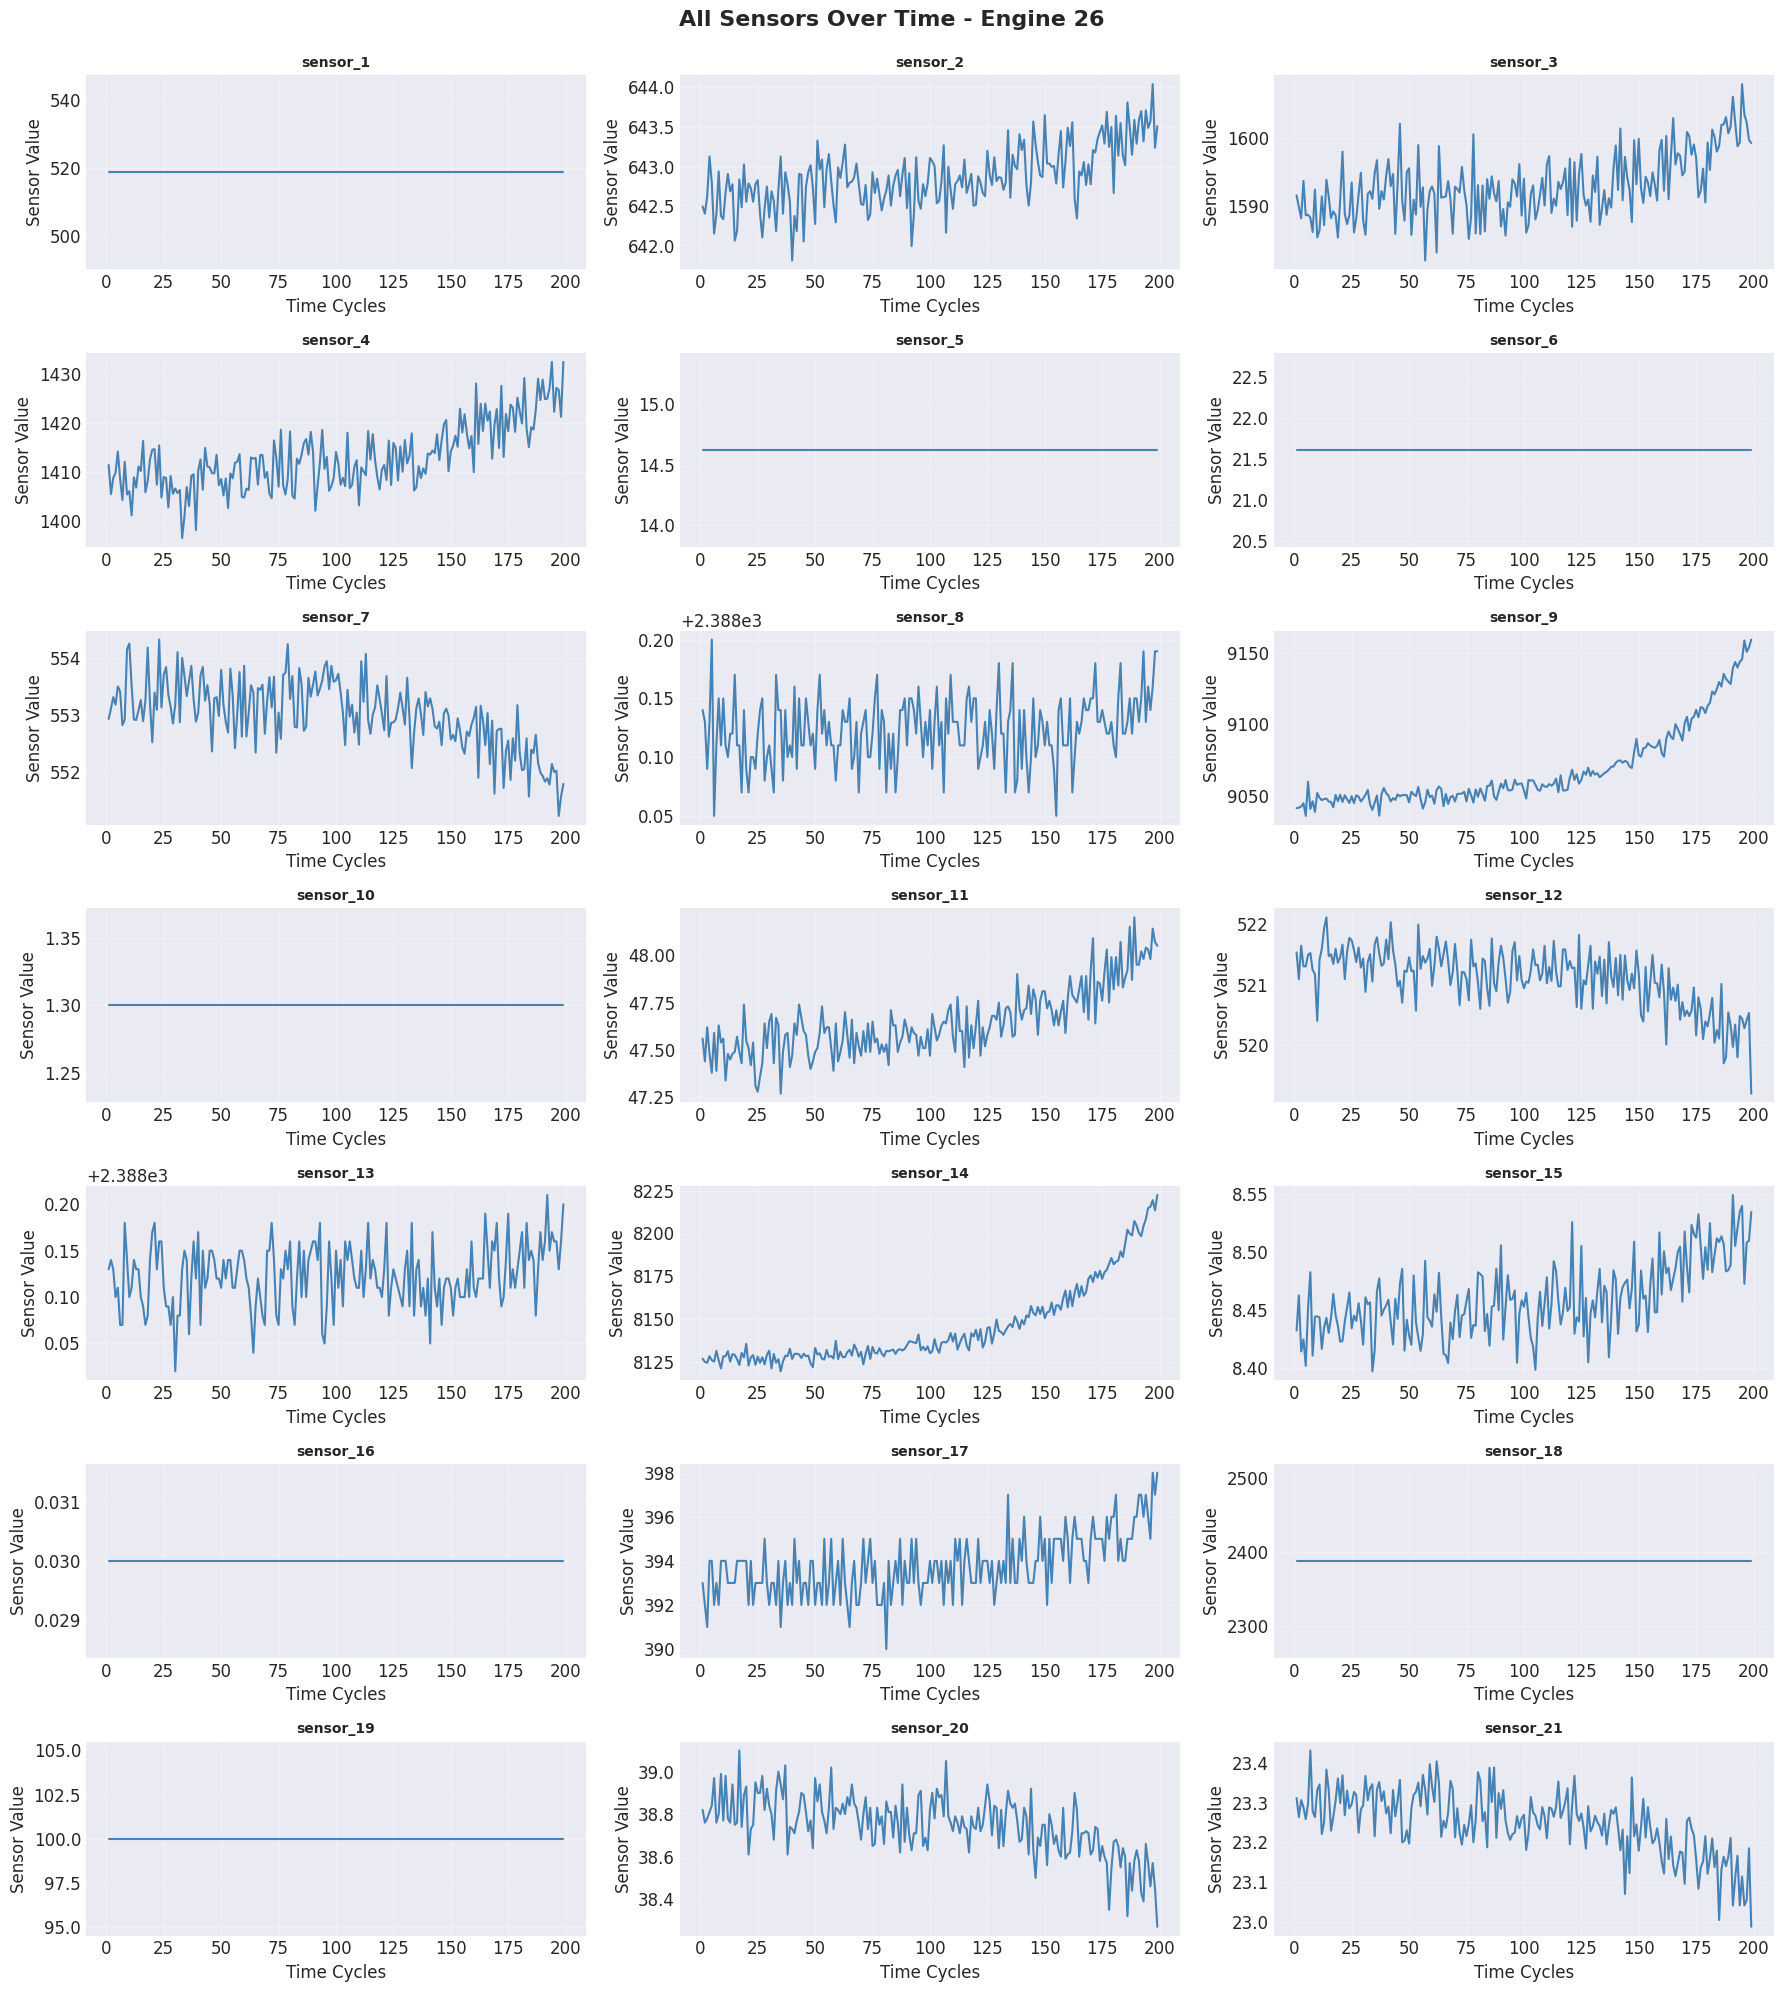


Sensor Variation Analysis for Engine 26

Sensors sorted by standard deviation:
   Sensor        Mean          Std       Min       Max    Range           CV
 sensor_9 9068.305126 2.832145e+01 9035.6900 9159.5100 123.8200 3.123125e-01
sensor_14 8145.527688 2.378836e+01 8119.6000 8222.4200 102.8200 2.920420e-01
 sensor_4 1413.012965 6.728192e+00 1396.5000 1432.5000  36.0000 4.761592e-01
 sensor_3 1593.003819 4.780023e+00 1581.9600 1607.9200  25.9600 3.000635e-01
sensor_17  393.788945 1.391053e+00  390.0000  398.0000   8.0000 3.532484e-01
 sensor_7  553.013668 5.981057e-01  551.2300  554.3200   3.0900 1.081539e-01
sensor_12  521.103618 4.891623e-01  519.2000  522.1100   2.9100 9.387045e-02
 sensor_2  642.873869 3.880677e-01  641.8200  644.0400   2.2200 6.036452e-02
sensor_11   47.648693 1.793712e-01   47.2700   48.2000   0.9300 3.764452e-01
sensor_20   38.752060 1.368523e-01   38.2700   39.1000   0.8300 3.531485e-01
sensor_21   23.249469 7.959730e-02   22.9867   23.4328   0.4461 3.423618e

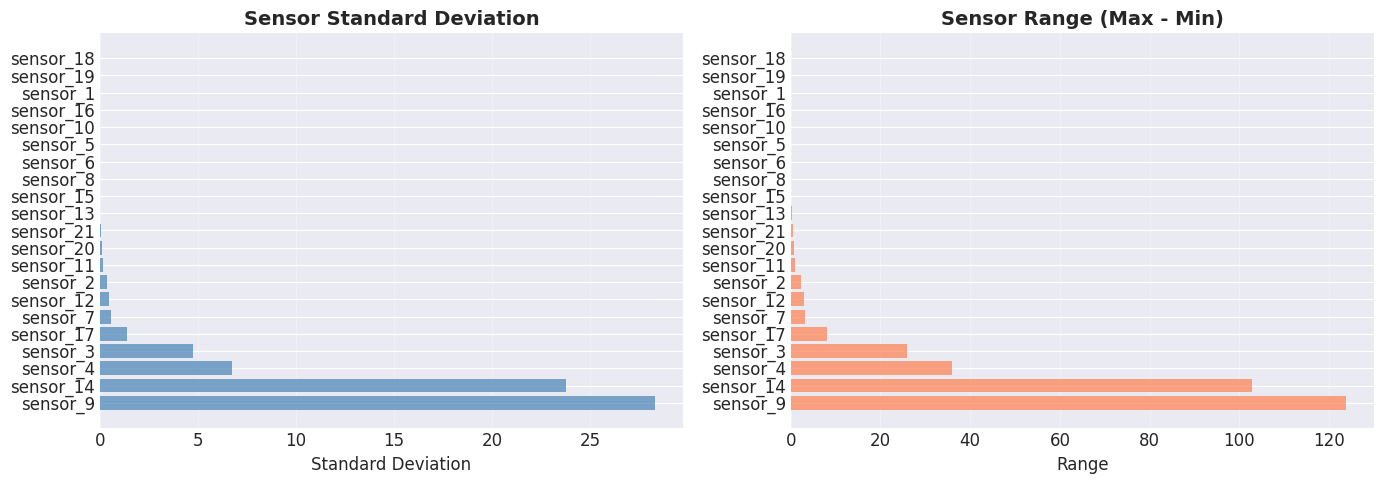

In [5]:
"""
Analyze one engine in detail to understand sensor behavior over time.
"""

# Select engine with median cycle length for representative analysis
cycle_lengths_fd001 = train_fd001.groupby('unit_number')['time_cycles'].max()
median_engine = cycle_lengths_fd001.sort_values().iloc[len(cycle_lengths_fd001)//2]
median_engine_id = cycle_lengths_fd001[cycle_lengths_fd001 == median_engine].index[0]

print(f"Selected Engine ID: {median_engine_id}")
print(f"Total cycles: {median_engine}")

# Extract data for this engine
engine_data = train_fd001[train_fd001['unit_number'] == median_engine_id].copy()

print(f"\nEngine {median_engine_id} data shape: {engine_data.shape}")
print(engine_data.head())

# Plot all sensors for this engine
fig, axes = plt.subplots(7, 3, figsize=(18, 20))
axes = axes.ravel()

for idx, sensor in enumerate(sensor_names):
    axes[idx].plot(engine_data['time_cycles'], engine_data[sensor], 
                   linewidth=1.5, color='steelblue')
    axes[idx].set_title(sensor, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Time Cycles')
    axes[idx].set_ylabel('Sensor Value')
    axes[idx].grid(alpha=0.3)

plt.suptitle(f'All Sensors Over Time - Engine {median_engine_id}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Identify sensors with significant variation
print("\n" + "=" * 80)
print("Sensor Variation Analysis for Engine", median_engine_id)
print("=" * 80)

sensor_stats = []
for sensor in sensor_names:
    values = engine_data[sensor]
    sensor_stats.append({
        'Sensor': sensor,
        'Mean': values.mean(),
        'Std': values.std(),
        'Min': values.min(),
        'Max': values.max(),
        'Range': values.max() - values.min(),
        'CV': (values.std() / values.mean() * 100) if values.mean() != 0 else 0  # Coefficient of Variation
    })

df_sensor_stats = pd.DataFrame(sensor_stats)
df_sensor_stats = df_sensor_stats.sort_values('Std', ascending=False)

print("\nSensors sorted by standard deviation:")
print(df_sensor_stats.to_string(index=False))

# Visualize sensor variation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard deviation
axes[0].barh(df_sensor_stats['Sensor'], df_sensor_stats['Std'], color='steelblue', alpha=0.7)
axes[0].set_title('Sensor Standard Deviation', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Standard Deviation')
axes[0].grid(axis='x', alpha=0.3)

# Range
axes[1].barh(df_sensor_stats['Sensor'], df_sensor_stats['Range'], color='coral', alpha=0.7)
axes[1].set_title('Sensor Range (Max - Min)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Range')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Sensor Analysis (Focus on FD001)

### 5.1 Sensors variance analysis
- Calculate variance for each sensor
- Identify sensors to potentially remove
- Visualize variance distribution

Sensor Variance Analysis (All Engines - FD001)

Sensors sorted by variance:
sensor_1     0.000000e+00
sensor_10    0.000000e+00
sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_16    1.203765e-35
sensor_5     2.840037e-29
sensor_6     1.929279e-06
sensor_15    1.406628e-03
sensor_8     5.038938e-03
sensor_13    5.172330e-03
sensor_21    1.171825e-02
sensor_20    3.266927e-02
sensor_11    7.133568e-02
sensor_2     2.500533e-01
sensor_12    5.439850e-01
sensor_7     7.833883e-01
sensor_17    2.398667e+00
sensor_3     3.759099e+01
sensor_4     8.101089e+01
sensor_14    3.639005e+02
sensor_9     4.876536e+02
dtype: float64

✗ Low variance sensors (variance < 0.01):
  - sensor_1: 0.000000
  - sensor_10: 0.000000
  - sensor_19: 0.000000
  - sensor_18: 0.000000
  - sensor_16: 0.000000
  - sensor_5: 0.000000
  - sensor_6: 0.000002
  - sensor_15: 0.001407
  - sensor_8: 0.005039
  - sensor_13: 0.005172


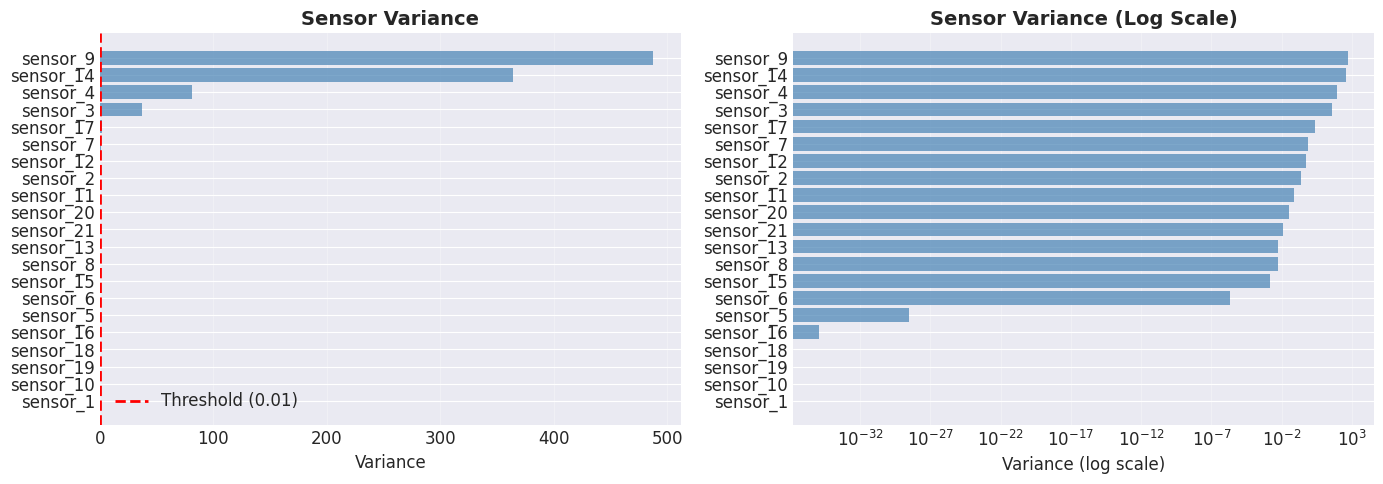


✓ Useful sensors (11): ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_14', 'sensor_17', 'sensor_20', 'sensor_21']


In [6]:
"""
Sensor Analysis - Focus on FD001

Constant/Low Variance Sensors
"""

# Calculate variance for each sensor across all engines
sensor_variances = train_fd001[sensor_names].var().sort_values()

print("=" * 80)
print("Sensor Variance Analysis (All Engines - FD001)")
print("=" * 80)
print("\nSensors sorted by variance:")
print(sensor_variances)

# Identify constant or near-constant sensors
threshold = 0.01
low_variance_sensors = sensor_variances[sensor_variances < threshold].index.tolist()

print(f"\n✗ Low variance sensors (variance < {threshold}):")
for sensor in low_variance_sensors:
    print(f"  - {sensor}: {sensor_variances[sensor]:.6f}")

# Visualize variance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].barh(range(len(sensor_variances)), sensor_variances.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(sensor_variances)))
axes[0].set_yticklabels(sensor_variances.index)
axes[0].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
axes[0].set_title('Sensor Variance', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Variance')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Log scale for better visualization
axes[1].barh(range(len(sensor_variances)), sensor_variances.values, color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(sensor_variances)))
axes[1].set_yticklabels(sensor_variances.index)
axes[1].set_xscale('log')
axes[1].set_title('Sensor Variance (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Variance (log scale)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Filter out low variance sensors for further analysis
useful_sensors = [s for s in sensor_names if s not in low_variance_sensors]
print(f"\n✓ Useful sensors ({len(useful_sensors)}): {useful_sensors}")


## 5.2. Sensor Correlation Analysis


Sensor Correlation Analysis


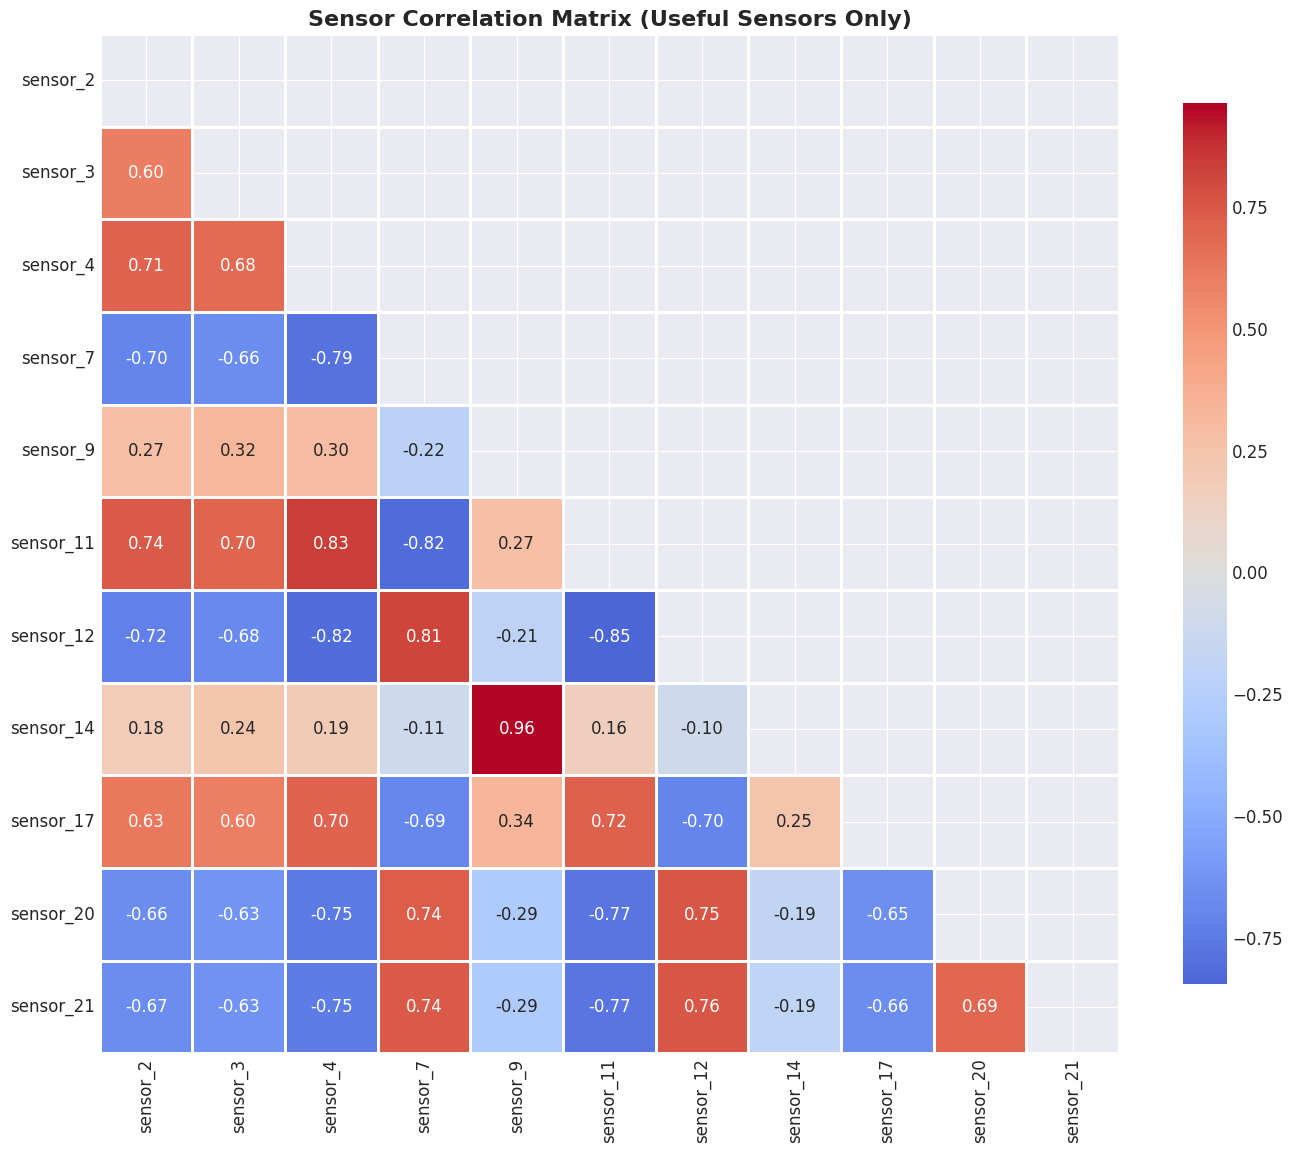


Highly correlated sensor pairs (|r| > 0.9):
Sensor 1  Sensor 2  Correlation
sensor_9 sensor_14     0.963157

⚠ Consider removing one sensor from each highly correlated pair to reduce multicollinearity

Sensor Trends Across Engine Lifetime
Analyzing top 6 varying sensors: ['sensor_9', 'sensor_14', 'sensor_4', 'sensor_3', 'sensor_17', 'sensor_7']


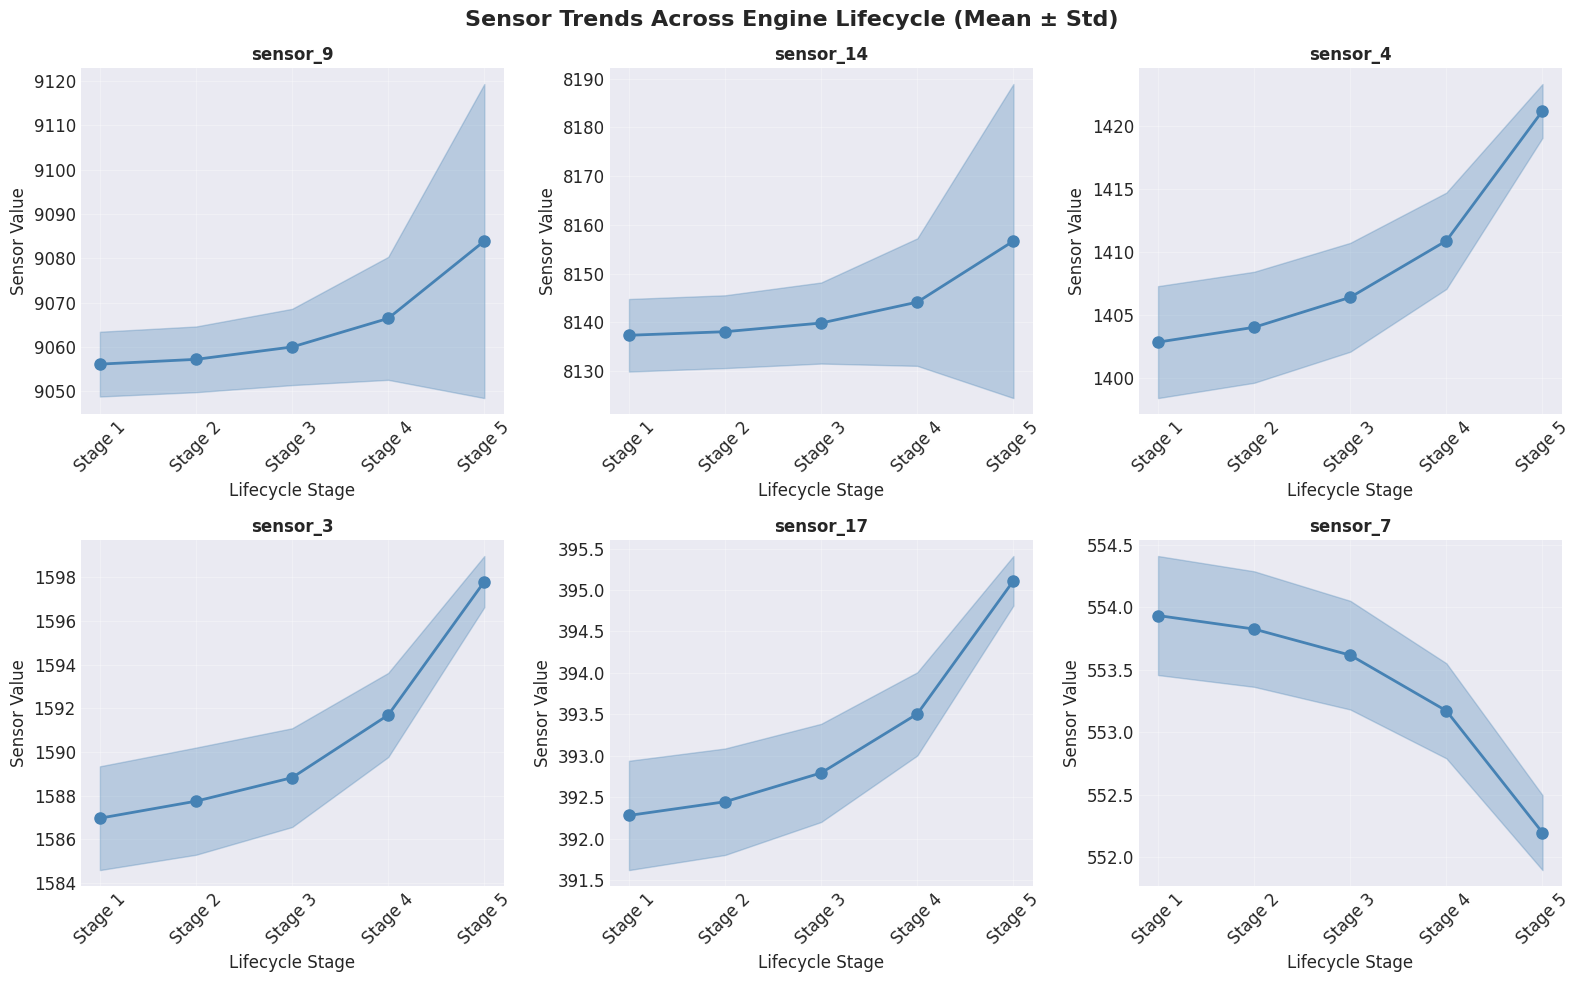


Early vs Late Life Comparison:
           Early Life (cycles ≤ 50)  Late Life (last 50 cycles)  Change (%)
sensor_9                    9056.20                     9081.91        0.28
sensor_14                   8137.42                     8155.34        0.22
sensor_4                    1403.02                     1419.78        1.19
sensor_3                    1587.04                     1596.92        0.62
sensor_17                    392.30                      394.89        0.66
sensor_7                     553.92                      552.34       -0.29


In [7]:
"""
5.2 Sensor Correlations
"""

print("\n" + "=" * 80)
print("Sensor Correlation Analysis")
print("=" * 80)

# Calculate correlation matrix (only useful sensors)
corr_matrix = train_fd001[useful_sensors].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Sensor Correlation Matrix (Useful Sensors Only)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated sensor pairs
high_corr_threshold = 0.9
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append({
                'Sensor 1': corr_matrix.columns[i],
                'Sensor 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    df_high_corr = pd.DataFrame(high_corr_pairs)
    print(f"\nHighly correlated sensor pairs (|r| > {high_corr_threshold}):")
    print(df_high_corr.to_string(index=False))
    print("\n⚠ Consider removing one sensor from each highly correlated pair to reduce multicollinearity")
else:
    print(f"\nNo sensor pairs with correlation > {high_corr_threshold}")

"""
### 5.3 Sensor Trends Across Engines
"""

print("\n" + "=" * 80)
print("Sensor Trends Across Engine Lifetime")
print("=" * 80)

# Select top varying sensors for visualization
top_sensors = sensor_variances[useful_sensors].nlargest(6).index.tolist()
print(f"Analyzing top 6 varying sensors: {top_sensors}")

# Calculate average sensor values at different lifecycle stages
def calculate_lifecycle_stages(df, n_stages=5):
    """Divide each engine's lifecycle into stages and calculate average sensor values"""
    results = []
    
    for unit in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == unit].copy()
        max_cycle = engine_data['time_cycles'].max()
        
        # Divide into stages
        engine_data['lifecycle_stage'] = pd.cut(
            engine_data['time_cycles'], 
            bins=n_stages, 
            labels=[f'Stage {i+1}' for i in range(n_stages)]
        )
        
        # Calculate mean for each stage
        stage_means = engine_data.groupby('lifecycle_stage')[top_sensors].mean()
        stage_means['unit_number'] = unit
        results.append(stage_means)
    
    return pd.concat(results)

lifecycle_data = calculate_lifecycle_stages(train_fd001)

# Plot sensor trends across lifecycle
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, sensor in enumerate(top_sensors):
    # Calculate mean and std for each stage
    stage_stats = lifecycle_data.groupby(level=0)[sensor].agg(['mean', 'std'])
    
    axes[idx].plot(stage_stats.index, stage_stats['mean'], 
                   marker='o', linewidth=2, markersize=8, color='steelblue')
    axes[idx].fill_between(range(len(stage_stats)), 
                           stage_stats['mean'] - stage_stats['std'],
                           stage_stats['mean'] + stage_stats['std'],
                           alpha=0.3, color='steelblue')
    axes[idx].set_title(sensor, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Lifecycle Stage')
    axes[idx].set_ylabel('Sensor Value')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xticklabels(stage_stats.index, rotation=45)

plt.suptitle('Sensor Trends Across Engine Lifecycle (Mean ± Std)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare early vs late life
print("\nEarly vs Late Life Comparison:")
early_life = train_fd001[train_fd001['time_cycles'] <= 50][top_sensors].mean()
late_life_engines = train_fd001.groupby('unit_number')['time_cycles'].max()
late_life_data = []

for unit in train_fd001['unit_number'].unique():
    max_cycle = late_life_engines[unit]
    unit_late = train_fd001[
        (train_fd001['unit_number'] == unit) & 
        (train_fd001['time_cycles'] > max_cycle - 50)
    ][top_sensors].mean()
    late_life_data.append(unit_late)

late_life = pd.DataFrame(late_life_data).mean()

comparison = pd.DataFrame({
    'Early Life (cycles ≤ 50)': early_life,
    'Late Life (last 50 cycles)': late_life,
    'Change (%)': ((late_life - early_life) / early_life * 100)
})

print(comparison.round(2))

Early vs Late Life Comparison: We see that sensor 9 increases by 0.28 % from early life to late life, while sensor 7 decreases from early life to late life by 0.29 %. Sensors with larger percentage changes are more useful for predicting failures. 

# 6. Operating Conditions Analysis
- Analyze operational setting distributions
- Check if settings change during engine lifetime
- Understand impact on sensor readings

Operating Settings Analysis

op_setting_1:
  Unique values: 158
  Mean: -0.0000
  Std: 0.0022
  Min: -0.0087
  Max: 0.0087

op_setting_2:
  Unique values: 13
  Mean: 0.0000
  Std: 0.0003
  Min: -0.0006
  Max: 0.0006

op_setting_3:
  Unique values: 1
  Mean: 100.0000
  Std: 0.0000
  Min: 100.0000
  Max: 100.0000


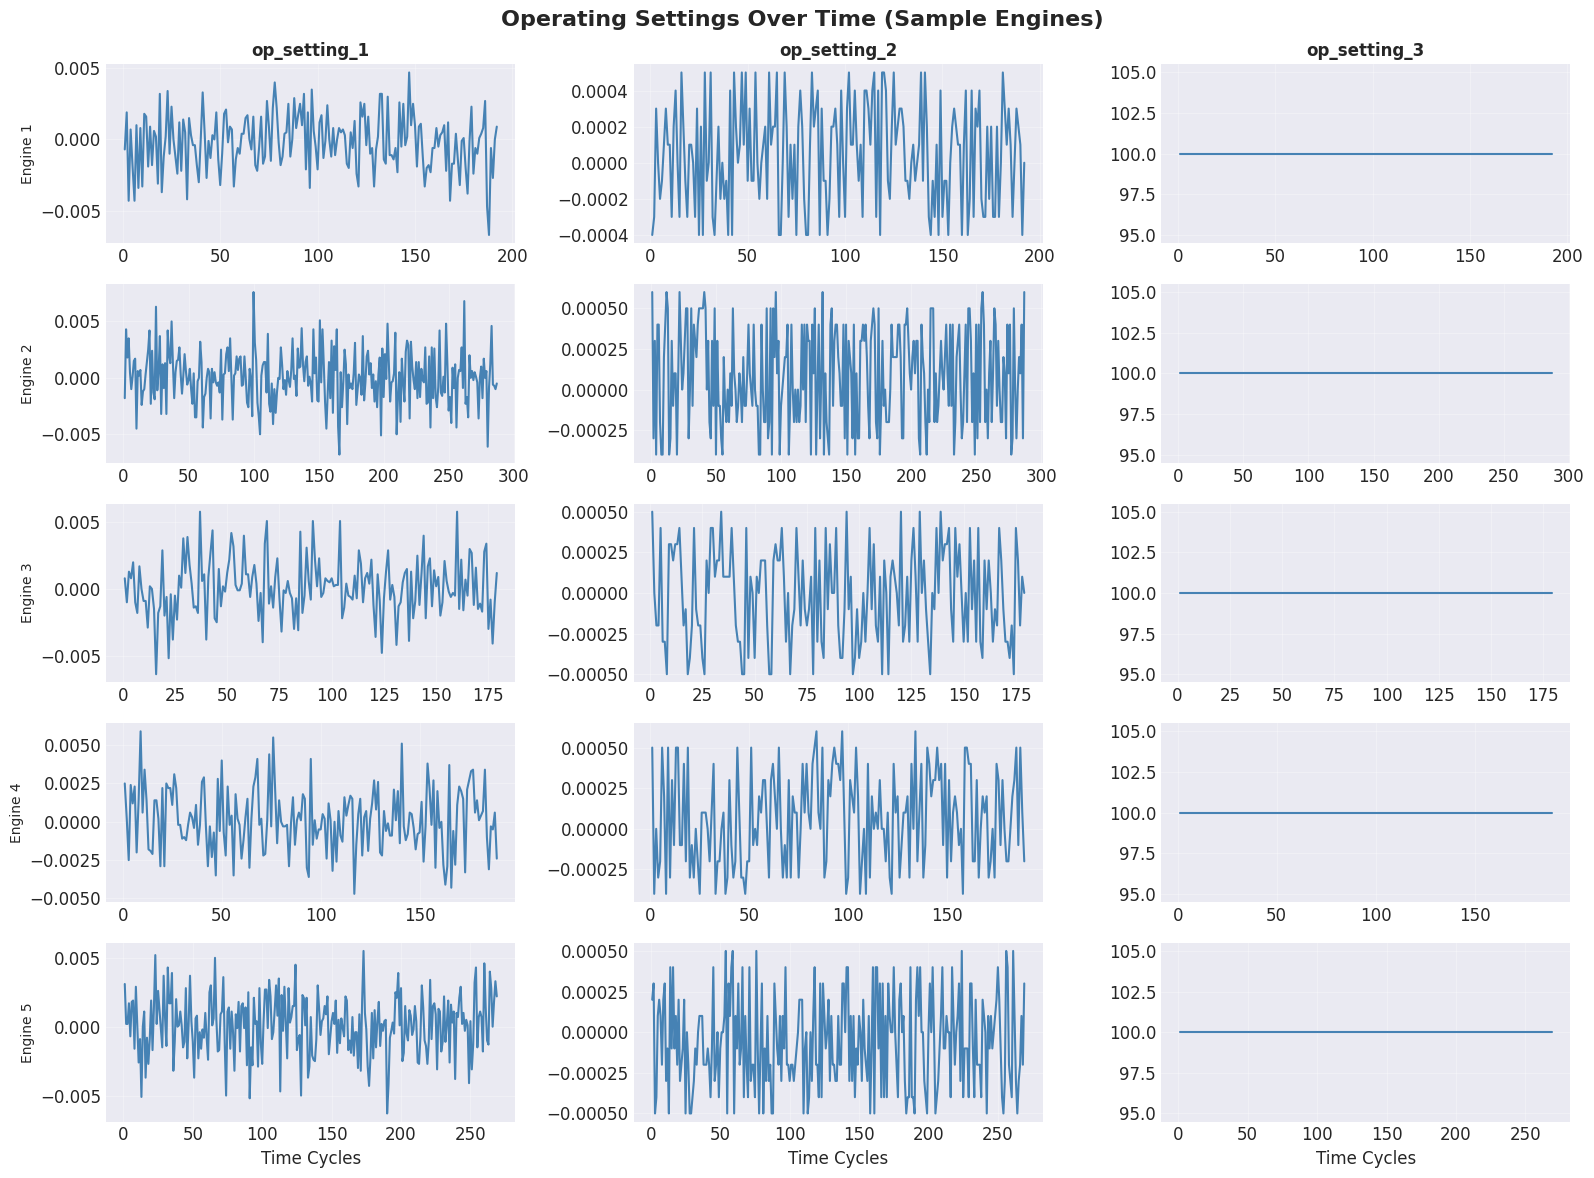


✓ FD001 has constant operating conditions (single operating condition mode)


In [ ]:
"""
## 6. Operating Conditions Analysis
"""

print("=" * 80)
print("Operating Settings Analysis")
print("=" * 80)

# Analyze operating settings
for setting in setting_names:
    print(f"\n{setting}:")
    print(f"  Unique values: {train_fd001[setting].nunique()}")
    print(f"  Mean: {train_fd001[setting].mean():.4f}")
    print(f"  Std: {train_fd001[setting].std():.4f}")
    print(f"  Min: {train_fd001[setting].min():.4f}")
    print(f"  Max: {train_fd001[setting].max():.4f}")

# Check if settings change over engine lifetime
sample_engines = train_fd001['unit_number'].unique()[:5]

fig, axes = plt.subplots(len(sample_engines), 3, figsize=(16, 12))

for engine_idx, engine_id in enumerate(sample_engines):
    engine_data = train_fd001[train_fd001['unit_number'] == engine_id]
    
    for setting_idx, setting in enumerate(setting_names):
        axes[engine_idx, setting_idx].plot(engine_data['time_cycles'], 
                                           engine_data[setting], 
                                           linewidth=1.5, color='steelblue')
        
        if engine_idx == 0:
            axes[engine_idx, setting_idx].set_title(setting, fontsize=12, fontweight='bold')
        
        if setting_idx == 0:
            axes[engine_idx, setting_idx].set_ylabel(f'Engine {engine_id}', fontsize=10)
        
        if engine_idx == len(sample_engines) - 1:
            axes[engine_idx, setting_idx].set_xlabel('Time Cycles')
        
        axes[engine_idx, setting_idx].grid(alpha=0.3)

plt.suptitle('Operating Settings Over Time (Sample Engines)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ FD001 has constant operating conditions (single operating condition mode)")

We see that the the operational setting 3 ist constant and operation 2 has the highest altitudes in varying conditions. 

## 7. Next steps
- Analyze remaining useful analysis (RUL) dataset
- See: *01_EDA_CMPASS_RUL.ipynb*